In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [2]:
print("Mounting your Google Drive ...")

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive',force_remount=True)
 
path = "/content/drive/My Drive/clases-II-2021/Machine-Learning/datasets/desafio02/"#Esta es la ruta

name_train = 'travel_packages_train.csv'
name_test = 'travel_packages_test.csv'

Mounting your Google Drive ...
Mounted at /content/drive


In [3]:
data_train = pd.read_csv(path+name_train,encoding='latin-1', index_col = 0)
data_train = data_train.dropna()
data_train.head()

,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,PPPrice
7919,North East - Gangtok and Lachung,Deluxe,Gangtok|Lachung|Gangtok,1N Gangtok . 2N Lachung . 1N Gangtok,Gangtok|Lachung|Gangtok,10-01-2022,Summit Denzong Hotel & Spa:4.5|Summit Alpine R...,New Delhi,Spicejet|Spicejet,1,3,Singhik View Point | Chungthang | Yumthang Va...,Cancellation any time after making the 1st pay...,284.0
982,Spiritual Haridwar from Delhi,Budget,Haridwar,2N Haridwar,Haridwar,21-11-2021,Not Available,Mumbai,Not Available,2,2,Har Ki Pauri,Cancellation any time after making the 1st pay...,129.0
3211,Rajasthan Adventure Special with Guided Leopar...,Premium,Jodhpur|Jaisalmer,2N Jodhpur . 2N Jaisalmer,Jodhpur|Jaisalmer,06-08-2021,Indana Palace Jodhpur:4.3|Jaisalmer Marriott R...,New Delhi,IndiGo,0,5,Hanwant Mahal | Candlelight Dinner in Jodhpur...,Cancellation any time after making the 1st pay...,311.0
3509,Bhutan 5N - Thimphu(2) Paro(3),Premium,Thimpu|Paro,2N Thimpu . 3N Paro,Thimpu|Paro,27-02-2021,Terma Linca Resort and Spa:4.5|Zhiwa Ling Hote...,New Delhi,Not Available,0,5,Simtokha Dzong | Memorial Chorten | Buddha Do...,Cancellation any time after making the 1st pay...,517.0
4820,Splendid North East - Pelling Special (Value a...,Deluxe,Gangtok|Pelling|Darjeeling,2N Gangtok . 1N Pelling . 2N Darjeeling,Gangtok|Pelling|Darjeeling,16-06-2021,Lemon Tree Hotel Gangtok:4.3|The Elgin Mount ...,New Delhi,Go Air,1,3,Changu Lake - Excursion | Baba Mandir | Tashi...,Cancellation any time after making the 1st pay...,336.0


In [4]:
data_test = pd.read_csv(path+name_test,encoding='latin-1', index_col = 0)
data_test = data_test.dropna()
data_test.head()

,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules
7798,A Joyful holiday in Kerala,Standard,Cochin|Munnar|Allepey|Kovalam and Poovar,1N Cochin . 2N Munnar . 1N Allepey . 2N Kovala...,Cochin|Munnar|Allepey|Kovalam and Poovar,17-03-2021,Quality Airport Hotel:4.1|Iceberg Hill Hotel-M...,New Delhi,IndiGo,2,3,Fort Cochin | Dutch Palace | Jewish Synagogue...,Cancellation any time after making the 1st pay...
1788,Udaipur and Jodhpur Holiday,Premium,Udaipur|Jodhpur,2N Udaipur . 2N Jodhpur,Udaipur|Jodhpur,05-05-2021,Fateh Prakash Palace by HRH Group of Hotels:4....,New Delhi,Not Available,0,5,Lake Pichola | Saheliyon ki Bari | City Palac...,Cancellation any time after making the 1st pay...
2084,Golden Triangle - Delhi Agra & Jaipur (Land),Premium,New Delhi|Agra|Jaipur,2N New Delhi . 1N Agra . 2N Jaipur,New Delhi|Agra|Jaipur,19-03-2021,Hilton Garden Inn New Delhi Saket:Five|Tajview...,Mumbai,Not Available,0,5,Convenience Value Pack for Sedan - MMT,Cancellation any time after making the 1st pay...
18361,"Holiday in Allepey, Thekkady and Munnar",Standard,Allepey|Thekkady|Munnar,1N Allepey . 1N Thekkady . 2N Munnar,Allepey|Thekkady|Munnar,22-11-2021,"Camelot Hotel, Alleppey- MMT Holidays Special:...",Mumbai,Air India,2,3,Backwaters | Periyar wildlife Sanctuary | Kat...,Cancellation any time after making the 1st pay...
13939,Sri Lanka with Galle,Standard,Kandy|Bentota|Galle|Colombo,2N Kandy . 1N Bentota . 1N Galle . 2N Colombo,Kandy|Bentota|Galle|Colombo,26-04-2021,Oak Ray City Hotel-MMT HOLIDAYS SPECIAL:4|Coco...,Mumbai,IndiGo|IndiGo|IndiGo|IndiGo,2,3,Not Available,Cancellation any time after making the 1st pay...


# Limpieza Dataset

In [5]:
pack_type = np.asarray(data_train['Package Type'].unique())
pack_type = pack_type.tolist()
pack_typeList = []

for fila in range(len(data_train.index.tolist())):
    pack_typeList.append(pack_type.index(data_train.iloc[fila][1]))

data_train['Package Type New'] = pack_typeList

In [6]:
pack_type = np.asarray(data_test['Package Type'].unique())
pack_type = pack_type.tolist()
pack_typeList = []

for fila in range(len(data_test.index.tolist())):
    pack_typeList.append(pack_type.index(data_test.iloc[fila][1]))

data_test['Package Type New'] = pack_typeList

In [7]:
data_train2 = data_train.drop(['Airline'],axis=1)
data_train2 = data_train2.drop('Package Type',axis=1)
data_train2 = data_train2.drop('Travel Date',axis=1)
data_train2 = data_train2.drop('Places Covered',axis=1)
#data_train2.head()

In [8]:
data_test2 = data_test.drop(['Airline'],axis=1)
data_test2 = data_test2.drop('Package Type',axis=1)
data_test2 = data_test2.drop(['Travel Date'],axis=1)
data_test2 = data_test2.drop(['Places Covered'],axis=1)
#data_test2.head()

In [9]:
cols = data_train2.columns.tolist()
cols = [cols[0]] + [cols[-1]] + cols[1:-1]
data_train2 = data_train2[cols]
#data_train2.head()

In [10]:
sightseeing=np.unique(data_test2['Sightseeing Places Covered'])
len(sightseeing)

1315

In [11]:
destination=np.unique(data_test2['Destination'])
#destination

# Preparación de data

```
# Tiene formato de código
```



In [12]:
def reglas_cancelacion(data):
  cancellation=np.unique(data['Cancellation Rules'])
  print(cancellation)

  data['Cancellation Rules'][data['Cancellation Rules']==cancellation[2]]=cancellation[1]

  data['Cancellation Rules']=data['Cancellation Rules'].astype('category')
  data['code cancellation rules'] = data['Cancellation Rules'].cat.codes
  codesCancelationRules=dict(enumerate(data['Cancellation Rules'].cat.categories ))
  #pd.get_dummies(data_test2['code cancellation rules'], prefix='Rule')

  return data,codesCancelationRules

In [13]:
def itinerario(data):
  itinerary = data['Itinerary']
  night=[]
  regresa=[]
  for paquete in itinerary:
    paquete = paquete.split('.')
    total=0
    inicio = paquete[0].split('N')[1].strip()
    final = paquete[-1].split('N')[1].strip()
    for noche in paquete:
      noche=noche.split('N')[0]
      total+=int(noche)
    night.append(total)
    if inicio==final: regresa.append(1)
    else: regresa.append(0)
  data['Nights'] = night
  data['Regresa'] = regresa
  return data

In [14]:
def puntaje_hoteles_paquetes(data):
  details=data['Hotel Details']
  hoteles = {}
  notita = {'One':1.0,'Two':2.0,'Three':3.0,'Four':4.0,'Five':5.0,'':'media'}
  ldl=[] #lista de listas de hoteles por paquete
  for detail in details:
    if detail != 'Not Available':
      detail=detail.split('|')
      lista_de_hoteles=[] #hoteles por paquete
      for hotel in detail:
        hotel = hotel.split(':')
        hotel_name = ':'.join(hotel[:-1])
        hotel_nota = hotel[-1]
        lista_de_hoteles.append(':'.join(hotel[:-1]))
        if hotel_name not in hoteles:
          hoteles[hotel_name]=[]
        if hotel_nota in notita:
          hoteles[hotel_name].append(notita[hotel_nota])
        else:
          hoteles[hotel_name].append(float(hotel_nota))
      ldl.append(lista_de_hoteles)
    else:
      ldl.append(['Not Available'])
    
  aux=[]
  all=[]
  for hotel in hoteles:
    cont=0
    for value in hoteles[hotel]:
      if value!='media':
        aux.append(value)
      else:
        cont+=1
    media= np.mean(aux)
    aux+=[media]*cont
    hoteles[hotel]= np.mean(aux)
    if not np.isnan(hoteles[hotel]):
      all.append(hoteles[hotel])
    aux=[]
  media_total=np.mean(all)
  hoteles['Not Available']=media_total
  for hotel in hoteles:
    if np.isnan(hoteles[hotel]):
      hoteles[hotel]=media_total
  puntaje_hoteles=[]
  for paquete in ldl:
    aux=[]
    for hotel in paquete:
      aux.append(hoteles[hotel])
    puntaje_hoteles.append(np.mean(aux))
  data['puntaje hoteles'] = puntaje_hoteles
  return data

In [15]:
def lugares_cubiertos(data):
  destination = data['Destination']
  covered=[]
  for places in destination:
    places=places.split('|')
    covered.append(len(places))
  data['# lugares cubiertos']=covered
  return data

def lugares_turisticos(data):
  destination = data['Sightseeing Places Covered']
  covered=[]
  for places in destination:
    places=places.split('|')
    covered.append(len(places))
  data['# lugares turisticos cubiertos']=covered
  return data

In [16]:
data_test2.head()

,Package Name,Destination,Itinerary,Hotel Details,Start City,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Package Type New
7798,A Joyful holiday in Kerala,Cochin|Munnar|Allepey|Kovalam and Poovar,1N Cochin . 2N Munnar . 1N Allepey . 2N Kovala...,Quality Airport Hotel:4.1|Iceberg Hill Hotel-M...,New Delhi,2,3,Fort Cochin | Dutch Palace | Jewish Synagogue...,Cancellation any time after making the 1st pay...,0
1788,Udaipur and Jodhpur Holiday,Udaipur|Jodhpur,2N Udaipur . 2N Jodhpur,Fateh Prakash Palace by HRH Group of Hotels:4....,New Delhi,0,5,Lake Pichola | Saheliyon ki Bari | City Palac...,Cancellation any time after making the 1st pay...,1
2084,Golden Triangle - Delhi Agra & Jaipur (Land),New Delhi|Agra|Jaipur,2N New Delhi . 1N Agra . 2N Jaipur,Hilton Garden Inn New Delhi Saket:Five|Tajview...,Mumbai,0,5,Convenience Value Pack for Sedan - MMT,Cancellation any time after making the 1st pay...,1
18361,"Holiday in Allepey, Thekkady and Munnar",Allepey|Thekkady|Munnar,1N Allepey . 1N Thekkady . 2N Munnar,"Camelot Hotel, Alleppey- MMT Holidays Special:...",Mumbai,2,3,Backwaters | Periyar wildlife Sanctuary | Kat...,Cancellation any time after making the 1st pay...,0
13939,Sri Lanka with Galle,Kandy|Bentota|Galle|Colombo,2N Kandy . 1N Bentota . 1N Galle . 2N Colombo,Oak Ray City Hotel-MMT HOLIDAYS SPECIAL:4|Coco...,Mumbai,2,3,Not Available,Cancellation any time after making the 1st pay...,0


In [17]:
data_train2,diccionario_train2=reglas_cancelacion(data_train2)
data_train2=itinerario(data_train2)
data_train2=puntaje_hoteles_paquetes(data_train2)
data_train2=lugares_cubiertos(data_train2)
data_train2=lugares_turisticos(data_train2)
data_train2.head()

['Cancellation any time after making the 1st payment instalment till the 2nd payment date:The entire amount paid as 1st payment instalment (deposit) would be non-refundable.Cancellation after 2nd payment instalment and before 3rd or final payment date:The total amount that was due at the 2nd payment instalment as per your payment schedule would be non-refundable; anything that you have paid over and above this amount would be refundable.Cancellation after 3rd or final payment date:The full amount paid by you would be non-refundable.'
 'GENERAL Please note that once your booking is confirmed, you will receive an e-mail as well as an SMS on your registered mobile number confirming your booking. However, if you would like to get in touch with us please call us on 0124-4859749. We are open from 8:00 am o?= 8:00 pm, seven days a week Please expect to receive your vouchers 72 hours before your departure date (subject to full payment of your package cost) Please note that these packages are c

,Package Name,Package Type New,Destination,Itinerary,Hotel Details,Start City,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,PPPrice,code cancellation rules,Nights,Regresa,puntaje hoteles,# lugares cubiertos,# lugares turisticos cubiertos
7919,North East - Gangtok and Lachung,0,Gangtok|Lachung|Gangtok,1N Gangtok . 2N Lachung . 1N Gangtok,Summit Denzong Hotel & Spa:4.5|Summit Alpine R...,New Delhi,1,3,Singhik View Point | Chungthang | Yumthang Va...,Cancellation any time after making the 1st pay...,284.0,0,4,1,4.044395,3,4
982,Spiritual Haridwar from Delhi,1,Haridwar,2N Haridwar,Not Available,Mumbai,2,2,Har Ki Pauri,Cancellation any time after making the 1st pay...,129.0,0,2,1,4.052135,1,1
3211,Rajasthan Adventure Special with Guided Leopar...,2,Jodhpur|Jaisalmer,2N Jodhpur . 2N Jaisalmer,Indana Palace Jodhpur:4.3|Jaisalmer Marriott R...,New Delhi,0,5,Hanwant Mahal | Candlelight Dinner in Jodhpur...,Cancellation any time after making the 1st pay...,311.0,0,4,0,4.464060,2,11
3509,Bhutan 5N - Thimphu(2) Paro(3),2,Thimpu|Paro,2N Thimpu . 3N Paro,Terma Linca Resort and Spa:4.5|Zhiwa Ling Hote...,New Delhi,0,5,Simtokha Dzong | Memorial Chorten | Buddha Do...,Cancellation any time after making the 1st pay...,517.0,0,5,0,4.500000,2,5
4820,Splendid North East - Pelling Special (Value a...,0,Gangtok|Pelling|Darjeeling,2N Gangtok . 1N Pelling . 2N Darjeeling,Lemon Tree Hotel Gangtok:4.3|The Elgin Mount ...,New Delhi,1,3,Changu Lake - Excursion | Baba Mandir | Tashi...,Cancellation any time after making the 1st pay...,336.0,0,5,0,4.239318,3,11


In [18]:
data_test2,diccionario_test2=reglas_cancelacion(data_test2)
data_test2=itinerario(data_test2)
data_test2=puntaje_hoteles_paquetes(data_test2)
data_test2=lugares_cubiertos(data_test2)
data_test2=lugares_turisticos(data_test2)
data_test2.head()

['Cancellation any time after making the 1st payment instalment till the 2nd payment date:The entire amount paid as 1st payment instalment (deposit) would be non-refundable.Cancellation after 2nd payment instalment and before 3rd or final payment date:The total amount that was due at the 2nd payment instalment as per your payment schedule would be non-refundable; anything that you have paid over and above this amount would be refundable.Cancellation after 3rd or final payment date:The full amount paid by you would be non-refundable.'
 "GENERAL Please note that once your booking is confirmed, you will receive an e-mail as well as an SMS on your registered mobile number confirming your booking. However, if you would like to get in touch with us please call us on 0124-4859749. We are open from 8:00 am â\x80\x93 8:00 pm, seven days a week Please expect to receive your vouchers 72 hours before your departure date (subject to full payment of your package cost) Please note that these packages

,Package Name,Destination,Itinerary,Hotel Details,Start City,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Package Type New,code cancellation rules,Nights,Regresa,puntaje hoteles,# lugares cubiertos,# lugares turisticos cubiertos
7798,A Joyful holiday in Kerala,Cochin|Munnar|Allepey|Kovalam and Poovar,1N Cochin . 2N Munnar . 1N Allepey . 2N Kovala...,Quality Airport Hotel:4.1|Iceberg Hill Hotel-M...,New Delhi,2,3,Fort Cochin | Dutch Palace | Jewish Synagogue...,Cancellation any time after making the 1st pay...,0,0,6,0,3.925501,4,12
1788,Udaipur and Jodhpur Holiday,Udaipur|Jodhpur,2N Udaipur . 2N Jodhpur,Fateh Prakash Palace by HRH Group of Hotels:4....,New Delhi,0,5,Lake Pichola | Saheliyon ki Bari | City Palac...,Cancellation any time after making the 1st pay...,1,0,4,0,4.171429,2,8
2084,Golden Triangle - Delhi Agra & Jaipur (Land),New Delhi|Agra|Jaipur,2N New Delhi . 1N Agra . 2N Jaipur,Hilton Garden Inn New Delhi Saket:Five|Tajview...,Mumbai,0,5,Convenience Value Pack for Sedan - MMT,Cancellation any time after making the 1st pay...,1,0,5,0,4.295084,3,1
18361,"Holiday in Allepey, Thekkady and Munnar",Allepey|Thekkady|Munnar,1N Allepey . 1N Thekkady . 2N Munnar,"Camelot Hotel, Alleppey- MMT Holidays Special:...",Mumbai,2,3,Backwaters | Periyar wildlife Sanctuary | Kat...,Cancellation any time after making the 1st pay...,0,0,4,0,3.931800,3,8
13939,Sri Lanka with Galle,Kandy|Bentota|Galle|Colombo,2N Kandy . 1N Bentota . 1N Galle . 2N Colombo,Oak Ray City Hotel-MMT HOLIDAYS SPECIAL:4|Coco...,Mumbai,2,3,Not Available,Cancellation any time after making the 1st pay...,0,0,6,0,4.009622,4,1


In [19]:
dummie_train2 = pd.get_dummies(data_train2['code cancellation rules'], prefix='Rule')

In [20]:
dummie_test2 = pd.get_dummies(data_test2['code cancellation rules'], prefix='Rule')

In [21]:
data_train2 = pd.concat([data_train2,dummie_train2],axis=1)
data_train2.head()

,Package Name,Package Type New,Destination,Itinerary,Hotel Details,Start City,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,PPPrice,code cancellation rules,Nights,Regresa,puntaje hoteles,# lugares cubiertos,# lugares turisticos cubiertos,Rule_0,Rule_1,Rule_2,Rule_3,Rule_4,Rule_5,Rule_6
7919,North East - Gangtok and Lachung,0,Gangtok|Lachung|Gangtok,1N Gangtok . 2N Lachung . 1N Gangtok,Summit Denzong Hotel & Spa:4.5|Summit Alpine R...,New Delhi,1,3,Singhik View Point | Chungthang | Yumthang Va...,Cancellation any time after making the 1st pay...,284.0,0,4,1,4.044395,3,4,1,0,0,0,0,0,0
982,Spiritual Haridwar from Delhi,1,Haridwar,2N Haridwar,Not Available,Mumbai,2,2,Har Ki Pauri,Cancellation any time after making the 1st pay...,129.0,0,2,1,4.052135,1,1,1,0,0,0,0,0,0
3211,Rajasthan Adventure Special with Guided Leopar...,2,Jodhpur|Jaisalmer,2N Jodhpur . 2N Jaisalmer,Indana Palace Jodhpur:4.3|Jaisalmer Marriott R...,New Delhi,0,5,Hanwant Mahal | Candlelight Dinner in Jodhpur...,Cancellation any time after making the 1st pay...,311.0,0,4,0,4.464060,2,11,1,0,0,0,0,0,0
3509,Bhutan 5N - Thimphu(2) Paro(3),2,Thimpu|Paro,2N Thimpu . 3N Paro,Terma Linca Resort and Spa:4.5|Zhiwa Ling Hote...,New Delhi,0,5,Simtokha Dzong | Memorial Chorten | Buddha Do...,Cancellation any time after making the 1st pay...,517.0,0,5,0,4.500000,2,5,1,0,0,0,0,0,0
4820,Splendid North East - Pelling Special (Value a...,0,Gangtok|Pelling|Darjeeling,2N Gangtok . 1N Pelling . 2N Darjeeling,Lemon Tree Hotel Gangtok:4.3|The Elgin Mount ...,New Delhi,1,3,Changu Lake - Excursion | Baba Mandir | Tashi...,Cancellation any time after making the 1st pay...,336.0,0,5,0,4.239318,3,11,1,0,0,0,0,0,0


In [22]:
data_test2 = pd.concat([data_test2,dummie_test2],axis=1)
data_test2.head()

,Package Name,Destination,Itinerary,Hotel Details,Start City,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Package Type New,code cancellation rules,Nights,Regresa,puntaje hoteles,# lugares cubiertos,# lugares turisticos cubiertos,Rule_0,Rule_1,Rule_2,Rule_3,Rule_4,Rule_5,Rule_6
7798,A Joyful holiday in Kerala,Cochin|Munnar|Allepey|Kovalam and Poovar,1N Cochin . 2N Munnar . 1N Allepey . 2N Kovala...,Quality Airport Hotel:4.1|Iceberg Hill Hotel-M...,New Delhi,2,3,Fort Cochin | Dutch Palace | Jewish Synagogue...,Cancellation any time after making the 1st pay...,0,0,6,0,3.925501,4,12,1,0,0,0,0,0,0
1788,Udaipur and Jodhpur Holiday,Udaipur|Jodhpur,2N Udaipur . 2N Jodhpur,Fateh Prakash Palace by HRH Group of Hotels:4....,New Delhi,0,5,Lake Pichola | Saheliyon ki Bari | City Palac...,Cancellation any time after making the 1st pay...,1,0,4,0,4.171429,2,8,1,0,0,0,0,0,0
2084,Golden Triangle - Delhi Agra & Jaipur (Land),New Delhi|Agra|Jaipur,2N New Delhi . 1N Agra . 2N Jaipur,Hilton Garden Inn New Delhi Saket:Five|Tajview...,Mumbai,0,5,Convenience Value Pack for Sedan - MMT,Cancellation any time after making the 1st pay...,1,0,5,0,4.295084,3,1,1,0,0,0,0,0,0
18361,"Holiday in Allepey, Thekkady and Munnar",Allepey|Thekkady|Munnar,1N Allepey . 1N Thekkady . 2N Munnar,"Camelot Hotel, Alleppey- MMT Holidays Special:...",Mumbai,2,3,Backwaters | Periyar wildlife Sanctuary | Kat...,Cancellation any time after making the 1st pay...,0,0,4,0,3.931800,3,8,1,0,0,0,0,0,0
13939,Sri Lanka with Galle,Kandy|Bentota|Galle|Colombo,2N Kandy . 1N Bentota . 1N Galle . 2N Colombo,Oak Ray City Hotel-MMT HOLIDAYS SPECIAL:4|Coco...,Mumbai,2,3,Not Available,Cancellation any time after making the 1st pay...,0,0,6,0,4.009622,4,1,1,0,0,0,0,0,0


In [23]:
data_train3 = data_train2.drop(['Package Name','Destination','Itinerary','Hotel Details','Start City','Sightseeing Places Covered','Cancellation Rules'],axis=1)
data_train3 = data_train3[['Package Type New','Flight Stops','Meals','code cancellation rules','Nights','Regresa','puntaje hoteles','# lugares cubiertos','# lugares turisticos cubiertos','Rule_0','Rule_1','Rule_2','Rule_3','Rule_4','Rule_5','Rule_6','PPPrice']]
data_train3.head()

,Package Type New,Flight Stops,Meals,code cancellation rules,Nights,Regresa,puntaje hoteles,# lugares cubiertos,# lugares turisticos cubiertos,Rule_0,Rule_1,Rule_2,Rule_3,Rule_4,Rule_5,Rule_6,PPPrice
7919,0,1,3,0,4,1,4.044395,3,4,1,0,0,0,0,0,0,284.0
982,1,2,2,0,2,1,4.052135,1,1,1,0,0,0,0,0,0,129.0
3211,2,0,5,0,4,0,4.464060,2,11,1,0,0,0,0,0,0,311.0
3509,2,0,5,0,5,0,4.500000,2,5,1,0,0,0,0,0,0,517.0
4820,0,1,3,0,5,0,4.239318,3,11,1,0,0,0,0,0,0,336.0


In [24]:
data_test3 = data_test2.drop(['Package Name','Destination','Itinerary','Hotel Details','Start City','Sightseeing Places Covered','Cancellation Rules'],axis=1)
data_test3 = data_test3[['Package Type New','Flight Stops','Meals','code cancellation rules','Nights','Regresa','puntaje hoteles','# lugares cubiertos','# lugares turisticos cubiertos','Rule_0','Rule_1','Rule_2','Rule_3','Rule_4','Rule_5','Rule_6']]
data_test3.head()

,Package Type New,Flight Stops,Meals,code cancellation rules,Nights,Regresa,puntaje hoteles,# lugares cubiertos,# lugares turisticos cubiertos,Rule_0,Rule_1,Rule_2,Rule_3,Rule_4,Rule_5,Rule_6
7798,0,2,3,0,6,0,3.925501,4,12,1,0,0,0,0,0,0
1788,1,0,5,0,4,0,4.171429,2,8,1,0,0,0,0,0,0
2084,1,0,5,0,5,0,4.295084,3,1,1,0,0,0,0,0,0
18361,0,2,3,0,4,0,3.931800,3,8,1,0,0,0,0,0,0
13939,0,2,3,0,6,0,4.009622,4,1,1,0,0,0,0,0,0


# Visualización

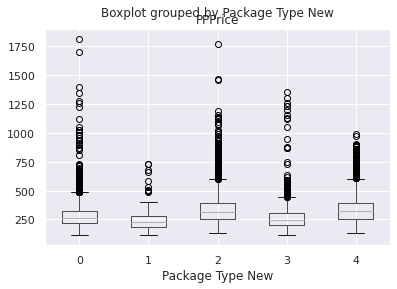

In [25]:
data_train3.boxplot(column=['PPPrice'],by='Package Type New')

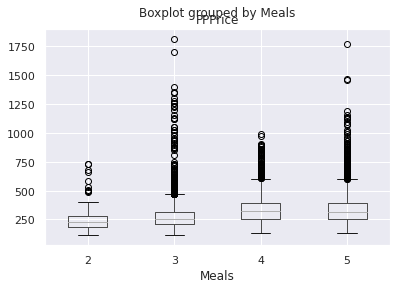

In [26]:
data_train3.boxplot(column=['PPPrice'],by='Meals')

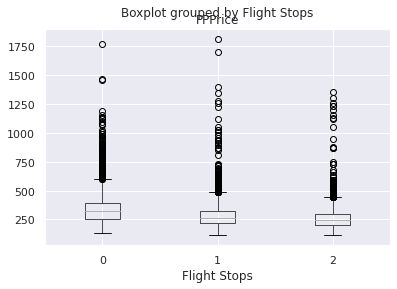

In [27]:
data_train3.boxplot(column=['PPPrice'],by='Flight Stops')

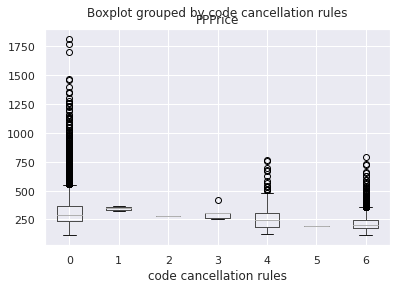

In [28]:
data_train3.boxplot(column=['PPPrice'],by='code cancellation rules')

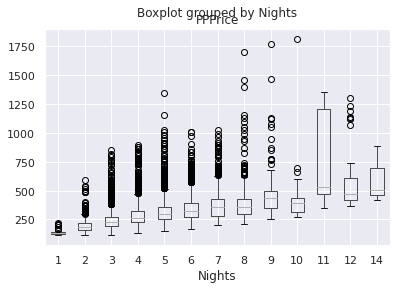

In [29]:
data_train3.boxplot(column=['PPPrice'],by='Nights')

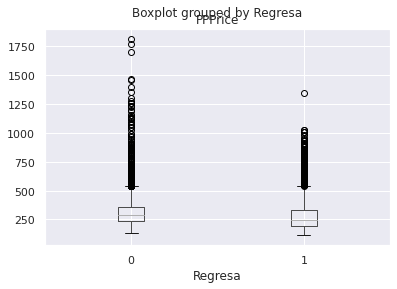

In [30]:
data_train3.boxplot(column=['PPPrice'],by='Regresa')

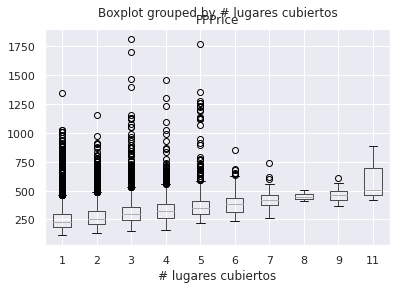

In [31]:
data_train3.boxplot(column=['PPPrice'],by='# lugares cubiertos')

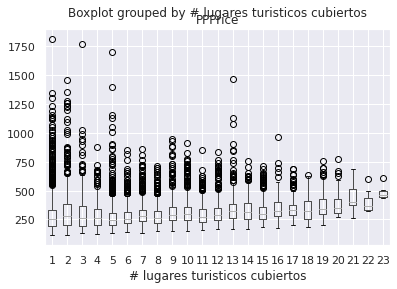

In [32]:
data_train3.boxplot(column=['PPPrice'],by='# lugares turisticos cubiertos')

# Aplicación de modelos

> 1: Regresion Lineal

> 2: Ridge

> 3: Lasso





In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

X = data_train3[['Package Type New','Flight Stops','Meals','code cancellation rules','Nights','Regresa','puntaje hoteles','# lugares cubiertos','# lugares turisticos cubiertos','Rule_1','Rule_2','Rule_3','Rule_4','Rule_5','Rule_6']]
y = data_train3['PPPrice'] 

X_train,X_test,Y_train, Y_test = train_test_split(X,y,test_size=0.33, random_state=2)

In [48]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
y_pred_1 = regressor.predict(X_test)
mean_absolute_percentage_error(Y_test, y_pred_1)

0.20839088357839677

In [49]:
from sklearn.model_selection import cross_validate
cv_validate1=cross_validate(regressor, X, y, cv=10, scoring='neg_mean_absolute_percentage_error')
cv_validate1['test_score']*(-100)

array([21.25132129, 21.32199847, 21.14033363, 20.61259191, 20.97083236,
       20.41442161, 20.80716131, 20.13769327, 20.81635729, 20.6884535 ])

In [50]:
from sklearn.linear_model import Ridge

alphas = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
for alpha in alphas:
  ridge = Ridge(alpha)
  ridge.fit(X_train,Y_train)
  y_pred_2 = ridge.predict(X_test)
  mape = mean_absolute_percentage_error(Y_test, y_pred_2)
  cv_validate2=cross_validate(ridge, X, y, cv=10, scoring='neg_mean_absolute_percentage_error')
  print('Para alpha =',alpha,'se tiene',mape)
  print(' ',cv_validate2['test_score']*(-100),'\n')

Para alpha = 0 se tiene 156076019.1557545
  [2.12448851e+01 2.13219985e+01 1.21851766e+11 2.06023483e+01
 2.09708324e+01 2.04144216e+01 2.08071613e+01 2.01199271e+01
 2.08163573e+01 7.36071201e+11] 

Para alpha = 0.05 se tiene 0.20839105393965485
  [21.25137939 21.32200695 21.13986552 20.61259776 20.97030214 20.41441416
 20.80716478 20.13770424 20.81668886 20.68847842] 

Para alpha = 0.1 se tiene 0.20839120769013564
  [21.25143594 21.32201477 21.13940984 20.61260337 20.96982289 20.41440718
 20.80716796 20.13771469 20.81699024 20.68850525] 

Para alpha = 0.15 se tiene 0.2083913458676048
  [21.25149099 21.32202193 21.13896605 20.61260871 20.96938783 20.41440019
 20.80717079 20.1377246  20.81726536 20.68853358] 

Para alpha = 0.2 se tiene 0.2083914694193658
  [21.25154456 21.32202844 21.13853361 20.61261377 20.96899135 20.41439316
 20.80717326 20.13773398 20.81751747 20.68856303] 

Para alpha = 0.25 se tiene 0.20839157921221138
  [21.25159669 21.32203429 21.13811205 20.61261852 20.9686287

In [51]:
from sklearn.linear_model import Lasso

alphas = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
for alpha in alphas:
  lasso = Lasso(alpha)
  lasso.fit(X_train,Y_train)
  y_pred_3 = lasso.predict(X_test)
  mape = mean_absolute_percentage_error(Y_test, y_pred_3)
  cv_validate3=cross_validate(ridge, X, y, cv=10, scoring='neg_mean_absolute_percentage_error')
  print('Para alpha =',alpha,'se tiene',mape)
  print(' ',cv_validate3['test_score']*(-100),'\n')

Para alpha = 0 se tiene 0.20838012551458313
  [21.25223155 21.32205429 21.132842   20.6126522  20.96548862 20.41426774
 20.80716266 20.13781738 20.81982259 20.68905726] 

Para alpha = 0.05 se tiene 0.20831828757527643
  [21.25223155 21.32205429 21.132842   20.6126522  20.96548862 20.41426774
 20.80716266 20.13781738 20.81982259 20.68905726] 

Para alpha = 0.1 se tiene 0.20821806175501217
  [21.25223155 21.32205429 21.132842   20.6126522  20.96548862 20.41426774
 20.80716266 20.13781738 20.81982259 20.68905726] 

Para alpha = 0.15 se tiene 0.20812218220650264
  [21.25223155 21.32205429 21.132842   20.6126522  20.96548862 20.41426774
 20.80716266 20.13781738 20.81982259 20.68905726] 

Para alpha = 0.2 se tiene 0.20803386637789334
  [21.25223155 21.32205429 21.132842   20.6126522  20.96548862 20.41426774
 20.80716266 20.13781738 20.81982259 20.68905726] 

Para alpha = 0.25 se tiene 0.20795615471929094
  [21.25223155 21.32205429 21.132842   20.6126522  20.96548862 20.41426774
 20.80716266 

In [52]:
nameSample = "sample_submission.csv"
df_sample = pd.read_csv(path+nameSample)

In [53]:
data_test3 = data_test3[['Package Type New','Flight Stops','Meals','code cancellation rules','Nights','Regresa','puntaje hoteles','# lugares cubiertos','# lugares turisticos cubiertos','Rule_1','Rule_2','Rule_3','Rule_4','Rule_5','Rule_6']]

y_test=regressor.predict(data_test3)
df_sample['PPPrice']=y_test
df_sample.to_csv(path+"sample_submission.csv",index=False)#josemiguel.csv